# Evaluation per quantile level

In [1]:
import pandas as pd
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_abline,
    geom_line,
    geom_point,
    ggplot,
    labs,
    scale_color_manual,
    scale_x_continuous,
    scale_y_continuous,
    theme,
    theme_bw,
)

from config import MAIN_MODELS, MODEL_COLORS, MODEL_ORDER, ROOT
from src.load_data import load_predictions
from src.scoring_functions import compute_scores

In [2]:
df = load_predictions()

# Prepare scores

In [3]:
df_scores = compute_scores(df)

In [4]:
df_scores = df_scores[df_scores["type"] == "quantile"]

In [5]:
df_scores["level"] = df_scores["age_group"].map(
    lambda x: "national" if x == "00+" else "age"
)
df_scores["level"] = pd.Categorical(
    df_scores["level"], categories=["national", "age"], ordered=True
)

In [6]:
df_scores = df_scores[df_scores.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df_scores.model.unique()]
df_scores["model"] = pd.Categorical(
    df_scores["model"], categories=model_order, ordered=True
)

In [7]:
df_qs = (
    df_scores.groupby(["level", "model", "quantile"], observed=True)["score"]
    .mean()
    .reset_index()
)

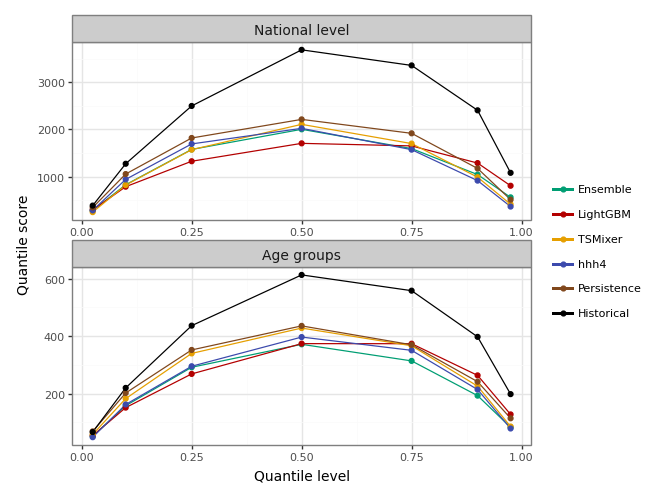

In [12]:
p = (
    ggplot(df_qs, aes(x="quantile", y="score", color="model"))
    + facet_wrap(
        "level",
        nrow=2,
        scales="free",
        labeller=lambda x: ("National level" if x == "national" else "Age groups"),
    )
    + geom_line()
    + geom_point()
    + scale_color_manual(values=MODEL_COLORS)
    + labs(x="Quantile level", y="Quantile score", color="", title="")
    # + scale_x_continuous(breaks=QUANTILES, labels=QUANTILES)
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title_position="top",
        legend_key=element_blank(),
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8),
    )
)
p

In [13]:
p.save(str(ROOT / "figures" / "qs.pdf"), width=160, height=90, units="mm", dpi=600, verbose=False)

c:\Users\tm7202\Workspace\replication-sari-forecasting\.venv\Lib\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

c:\Users\tm7202\Workspace\replication-sari-forecasting\.venv\Lib\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



IndexError: list index out of range

# Coverage

In [9]:
df["covered"] = df.truth <= df.value

In [10]:
df_coverage = (
    df[df.age_group == "00+"]
    .groupby(["model", "quantile"])["covered"]
    .mean()
    .reset_index()
)

In [11]:
df_coverage = df_coverage[df_coverage.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df_coverage.model.unique()]
df_coverage["model"] = pd.Categorical(
    df_coverage["model"], categories=model_order, ordered=True
)

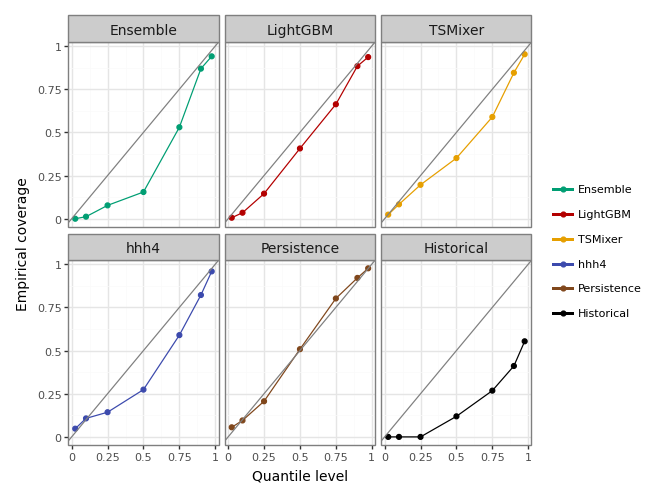

In [12]:
q = (
    ggplot(df_coverage, aes(x="quantile", y="covered", color="model"))
    + facet_wrap("model")
    + geom_line()
    + geom_point()
    + geom_abline(slope=1, intercept=0, linetype="solid", color="gray")
    + scale_color_manual(values=MODEL_COLORS)
    + labs(x="Quantile level", y="Empirical coverage", color="")
    + scale_x_continuous(
        labels=lambda x: [f"{int(v)}" if v == int(v) else f"{v}" for v in x]
    )
    + scale_y_continuous(
        labels=lambda x: [f"{int(v)}" if v == int(v) else f"{v}" for v in x]
    )
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title_position="top",
        legend_key=element_blank(),
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8),
    )
)
q

In [ ]:
q.save(
    "../figures/quantile_coverage.pdf",
    width=160,
    height=90,
    units="mm",
    dpi=600,
    verbose=False,
)